In [28]:
# %% Imports & helpers for SonoptixECHO-only workflow
import json, struct, hashlib
from pathlib import Path
from typing import List, Dict, Tuple, Union, Optional

import numpy as np
import pandas as pd
from rosbags.highlevel import AnyReader
from rosbags.typesys import register_types, get_types_from_msg

# --- utils ---
def base_msgtype(s: str) -> str:
    return s.rsplit("/", 1)[-1] if s else s

def sha256_f32_le(arr_f32: np.ndarray) -> str:
    """Hash of raw float32 little-endian bytes (exact payload fidelity check)."""
    arr = np.asarray(arr_f32, dtype=np.float32, order="C")
    return hashlib.sha256(arr.tobytes(order="C")).hexdigest()

def ensure_types_from_reader(reader) -> int:
    additions = {}
    for c in reader.connections:
        try:
            pkg_prefix = c.msgtype.rsplit("/", 1)[0]
            if getattr(c, "msgdef", None):
                additions.update(get_types_from_msg(c.msgdef, pkg_prefix))
        except Exception:
            pass
    if additions:
        register_types(additions)
        return len(additions)
    return 0

def decode_float32_multiarray(ma):
    """
    Decode ROS Float32MultiArray into labels, sizes, strides, payload, shape, data_offset.
    """
    dims = list(getattr(ma.layout, "dim", []) or [])
    labels  = [str(getattr(d, "label", "") or "") for d in dims]
    sizes   = [int(getattr(d, "size", 0) or 0) for d in dims]
    strides = [int(getattr(d, "stride", 0) or 0) for d in dims]
    data_off = int(getattr(ma.layout, "data_offset", 0) or 0)

    # Robustly get raw data
    raw = getattr(ma, "data", None)
    if raw is None:
        data = np.array([], dtype=np.float32)
    else:
        data = np.array(raw, dtype=np.float32)

    if data_off > 0 and data.size > data_off:
        data = data[data_off:]

    if not sizes:  # no layout info
        return labels, sizes, strides, data.tolist(), None, data_off

    prod = np.prod(sizes)
    if data.size < prod:
        prod = data.size

    shape = tuple(sizes)
    try:
        arr = data.reshape(shape, order="C")
    except Exception:
        # fallback to flat
        return labels, sizes, strides, data.tolist(), None, data_off

    # Try to detect a 2D shape (H, W)
    if arr.ndim >= 2:
        H, W = arr.shape[-2], arr.shape[-1]
        if H * W == arr.size:
            arr2 = arr.reshape(H, W)
            return labels, sizes, strides, arr2.tolist(), (H, W), data_off

    return labels, sizes, strides, arr.tolist(), tuple(arr.shape), data_off


In [29]:
# %% Fix Sonoptix extraction: diagnose + robust export
import json, re, hashlib
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union

import numpy as np
import pandas as pd
from rosbags.highlevel import AnyReader
from rosbags.typesys import get_types_from_msg, register_types

# ------------------------- Helpers -------------------------

def ensure_types_from_reader(reader) -> int:
    """Register all message definitions present in this bag."""
    additions = {}
    for c in reader.connections:
        try:
            pkg_prefix = c.msgtype.rsplit("/", 1)[0]  # e.g. 'sensors/msg'
            if getattr(c, "msgdef", None):
                additions.update(get_types_from_msg(c.msgdef, pkg_prefix))
        except Exception:
            pass
    if additions:
        register_types(additions)
        return len(additions)
    return 0

def base_msgtype(s: str) -> str:
    return s.rsplit("/", 1)[-1] if s else s

def _extract_times(msg, t_ns):
    """(t_header, t_bag, t_use, t_src) in seconds."""
    t_bag = float(t_ns) * 1e-9 if t_ns is not None else None
    t_hdr = None
    for p in (("header","stamp","sec","nanosec"), ("header","stamp","secs","nsecs")):
        try:
            sec = getattr(getattr(getattr(msg, p[0]), p[1]), p[2])
            nsc = getattr(getattr(getattr(msg, p[0]), p[1]), p[3])
            t_hdr = float(sec) + float(nsc) * 1e-9
            break
        except Exception:
            pass
    if t_hdr is not None and t_hdr > 0:
        return t_hdr, t_bag, t_hdr, "header"
    return t_hdr, t_bag, t_bag, "bag"

def _period_of(seq: List) -> int:
    """Smallest repeating period if seq is periodic; else len(seq)."""
    n = len(seq)
    for p in range(1, min(8, n) + 1):
        if n % p == 0 and seq == seq[:p] * (n // p):
            return p
    return n

def decode_float32_multiarray_fixed(ma):
    """
    Robust decoder for std_msgs/Float32MultiArray-like objects.
    Collapses accidental repeated dim blocks (e.g., ['height','width'] * K).
    Returns: labels, sizes, strides, payload (list or 2D list), (H,W)|None, data_offset
    """
    # layout fields
    dims = list(getattr(getattr(ma, "layout", None), "dim", []) or [])
    labels  = [str(getattr(d, "label", "") or "") for d in dims]
    sizes   = [int(getattr(d, "size", 0) or 0) for d in dims]
    strides = [int(getattr(d, "stride", 0) or 0) for d in dims]
    data_off = int(getattr(getattr(ma, "layout", None), "data_offset", 0) or 0)

    # data (avoid ambiguous truth)
    raw = getattr(ma, "data", None)
    if raw is None:
        data = np.array([], dtype=np.float32)
    else:
        data = np.asarray(list(raw), dtype=np.float32)

    if data_off > 0:
        data = data[data_off:]

    # If publisher duplicated dims in blocks (very common bug), compress them.
    if len(labels) >= 2:
        p_lab = _period_of(labels)
        p_sz  = _period_of(sizes) if sizes else len(sizes)
        p = min(p_lab, p_sz)
        if p < len(labels):
            # verify repeated blocks are identical for both labels and sizes
            if labels == labels[:p] * (len(labels)//p) and (not sizes or sizes == sizes[:p] * (len(sizes)//p)):
                labels  = labels[:p]
                sizes   = sizes[:p]
                strides = strides[:p] if strides else strides

    # Drop trailing singleton dims (e.g., channel=1) when safe
    while sizes and sizes[-1] == 1 and len(sizes) > 2:
        sizes.pop(); labels.pop()
        if strides: strides.pop()

    # Derive shape
    shape = tuple(sizes) if sizes else None
    flat = data
    if not sizes:
        # Flat vector only; no shape info
        return labels, sizes, strides, flat.astype(float).tolist(), None, data_off

    # Try exact reshape
    prod = np.prod([max(1, s) for s in sizes], dtype=np.int64)
    if prod == flat.size and prod > 0:
        try:
            arr = flat.reshape(shape)
            # Prefer (H,W) if array is 2D
            if arr.ndim == 2:
                H, W = arr.shape
                return labels, sizes, strides, arr.astype(float).tolist(), (int(H), int(W)), data_off
            # Common 3D case HxWxC -> take first channel
            if arr.ndim == 3 and arr.shape[-1] in (1, 2, 3, 4):
                H, W = arr.shape[0], arr.shape[1] if labels[:2] == ["height", "width"] else arr.shape[-3:-1]
                H, W = int(arr.shape[0]), int(arr.shape[1])
                img = arr[..., 0]
                return labels, sizes, strides, img.astype(float).tolist(), (H, W), data_off
        except Exception:
            pass

    # Fallback: use last two dims if they multiply to data length
    if len(sizes) >= 2:
        H, W = int(sizes[-2]), int(sizes[-1])
        if H > 0 and W > 0 and H * W == flat.size:
            img = flat.reshape((H, W))
            return labels[-2:], [H, W], (strides[-2:] if strides else []), img.astype(float).tolist(), (H, W), data_off

    # Final fallback: give flat payload
    return labels, sizes, strides, flat.astype(float).tolist(), None, data_off

def hash_payload_f32(payload_list) -> str:
    """Stable SHA256 of float32 payload."""
    a = np.asarray(payload_list, dtype=np.float32).ravel()
    return hashlib.sha256(a.tobytes()).hexdigest()

def decode_sensor_msgs_image(msg):
    """
    Decode a sensor_msgs/Image into 2D float array if possible.
    Supports encodings: '32FC1', '32FC', 'mono8', '8UC1', 'mono16', '16UC1'.
    Returns (img2d:np.ndarray(float32), (H,W)) or (None, None) on failure.
    """
    try:
        H = int(getattr(msg, "height", 0)); W = int(getattr(msg, "width", 0))
        enc = str(getattr(msg, "encoding", "") or "").upper()
        is_be = int(getattr(msg, "is_bigendian", 0) or 0) != 0
        step = int(getattr(msg, "step", 0) or 0)
        data = bytes(getattr(msg, "data", b"") or b"")
        if H <= 0 or W <= 0 or not data:
            return None, None

        # Map encoding -> dtype & channels
        if enc in ("32FC1", "32FC"):
            dtype, ch = np.float32, 1
        elif enc in ("MONO8", "8UC1"):
            dtype, ch = np.uint8, 1
        elif enc in ("MONO16", "16UC1"):
            dtype, ch = np.uint16, 1
        else:
            return None, None

        arr = np.frombuffer(data, dtype=dtype)
        if is_be and arr.dtype.byteorder != ">":
            arr = arr.byteswap().newbyteorder()
        if step and step != W * arr.dtype.itemsize * ch:
            # respect row stride
            row_bytes = step
            full = np.frombuffer(data, dtype=np.uint8).reshape(H, row_bytes)
            arr = full[:, : W * arr.dtype.itemsize * ch].view(dtype).reshape(H, W * ch)

        if ch == 1:
            img = arr.reshape(H, W).astype(np.float32, copy=False)
        else:
            img = arr.reshape(H, W, ch)[..., 0].astype(np.float32, copy=False)

        return img, (H, W)
    except Exception:
        return None, None

# ------------------------- Diagnose layout -------------------------

def probe_sonoptix_layout(bagpath: Union[str, Path], topic_regex=r"/sonoptix|/echo"):
    bagpath = Path(bagpath)
    with AnyReader([bagpath]) as reader:
        ensure_types_from_reader(reader)
        conns = [c for c in reader.connections if re.search(topic_regex, c.topic, re.I)]
        print(f"Found {len(conns)} Sonoptix-related connections in {bagpath.name}:")
        for c in conns:
            print(f"  - {c.topic}  [{c.msgtype}]")
        if not conns:
            return

        # Peek one message from the first relevant connection
        con = conns[0]
        for con1, t_ns, raw in reader.messages(connections=[con], start=0, stop=1):
            msg = reader.deserialize(raw, con.msgtype)
            print("\nSample message introspection:")
            if hasattr(msg, "array_data"):
                labs, sz, strd, payload, shape, off = decode_float32_multiarray_fixed(msg.array_data)
                print(f"  array_data dims: labels={labs} sizes={sz} (offset={off}) shape={shape}  payload_len={len(payload) if isinstance(payload, list) else '2D'}")
            elif base_msgtype(con.msgtype) == "Image":
                img, shape = decode_sensor_msgs_image(msg)
                print(f"  sensor_msgs/Image: encoding={getattr(msg,'encoding','?')} HxW={shape} bytes={len(getattr(msg,'data',b''))}")
            else:
                print("  (No array_data; unsupported type for this probe.)")

# ------------------------- Exporter -------------------------

def export_sonoptix_echo_from_bag(bagpath: Union[str, Path],
                                  out_csv: Union[str, Path],
                                  topic_regex=r"/sonoptix|/echo") -> pd.DataFrame:
    bagpath = Path(bagpath)
    rows: List[Dict] = []
    with AnyReader([bagpath]) as reader:
        ensure_types_from_reader(reader)
        conns = [c for c in reader.connections if re.search(topic_regex, c.topic, re.I)]
        if not conns:
            raise RuntimeError(f"No topics matching {topic_regex!r} in {bagpath}.")

        for con in conns:
            for con1, t_ns, raw in reader.messages(connections=[con]):
                msg = reader.deserialize(raw, con.msgtype)
                t_hdr, t_bag, t_use, t_src = _extract_times(msg, t_ns)

                # Path A: custom SonoptixECHO with Float32MultiArray
                if hasattr(msg, "array_data"):
                    labs, sz, strd, payload, shape, off = decode_float32_multiarray_fixed(msg.array_data)
                    rec = {
                        "t": t_use, "t_header": t_hdr, "t_bag": t_bag, "t_src": t_src,
                        "bag": bagpath.stem, "bag_file": bagpath.name, "topic": con.topic,
                        "dim_labels": json.dumps(labs, ensure_ascii=False),
                        "dim_sizes": json.dumps(sz, ensure_ascii=False),
                        "dim_strides": json.dumps(strd, ensure_ascii=False),
                        "data_offset": int(off),
                        "dtype": "float32",
                    }
                    if shape is not None:
                        H, W = shape
                        rec["rows"] = int(H); rec["cols"] = int(W)
                        rec["payload_sha256"] = hash_payload_f32(payload)
                        rec["image"] = json.dumps(payload, ensure_ascii=False)
                    else:
                        # keep flat
                        rec["rows"] = 1; rec["cols"] = int(len(payload))
                        rec["payload_sha256"] = hash_payload_f32(payload)
                        rec["image"] = json.dumps(payload, ensure_ascii=False)
                    rows.append(rec)
                    continue

                # Path B: sonar as sensor_msgs/Image (e.g., topic '/sensor/sonoptix_echo/image')
                if base_msgtype(con.msgtype) == "Image":
                    img, shape = decode_sensor_msgs_image(msg)
                    if img is None:
                        continue
                    H, W = shape
                    rec = {
                        "t": t_use, "t_header": t_hdr, "t_bag": t_bag, "t_src": t_src,
                        "bag": bagpath.stem, "bag_file": bagpath.name, "topic": con.topic,
                        "dim_labels": json.dumps(["height","width"], ensure_ascii=False),
                        "dim_sizes": json.dumps([H, W], ensure_ascii=False),
                        "dim_strides": json.dumps([], ensure_ascii=False),
                        "data_offset": 0,
                        "dtype": "float32",
                        "rows": int(H), "cols": int(W),
                        "payload_sha256": hashlib.sha256(img.astype(np.float32, copy=False).tobytes()).hexdigest(),
                        "image": json.dumps(img.astype(float).tolist(), ensure_ascii=False),
                    }
                    rows.append(rec)
                    continue

                # Otherwise skip
                continue

    if not rows:
        raise RuntimeError("No Sonoptix frames decoded.")

    df = pd.DataFrame(rows).dropna(subset=["t"]).sort_values("t").reset_index(drop=True)
    df["t0"] = df["t"].iloc[0]
    df["t_rel"] = df["t"] - df["t0"]

    out_csv = Path(out_csv); out_csv.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_csv, index=False)
    print(f"Wrote {out_csv} ({len(df)} frames).")
    # Show a quick preview row (dim_labels should be short: ['height','width'])
    with pd.option_context("display.max_colwidth", 120):
        display(df.head(2)[["topic","dim_labels","dim_sizes","rows","cols","payload_sha256"]])
    return df

# ------------------------- Run: probe + export -------------------------

BAG_PATH = "data/2024-08-20_13-39-34_video.bag"   # ← change if needed
TOPIC_REGEX = r"/sensor/sonoptix_echo"            # narrow to your sonar topic
OUT_CSV = "exports/by_bag/sonoptix_echo__test.csv"

probe_sonoptix_layout(BAG_PATH, TOPIC_REGEX)
df_echo = export_sonoptix_echo_from_bag(BAG_PATH, OUT_CSV, TOPIC_REGEX)


Found 1 Sonoptix-related connections in 2024-08-20_13-39-34_video.bag:
  - /sensor/sonoptix_echo/image  [sensors/msg/SonoptixECHO]
Wrote exports/by_bag/sonoptix_echo__test.csv (699 frames).


,topic,dim_labels,dim_sizes,rows,cols,payload_sha256
0,/sensor/sonoptix_echo/image,"[""height"", ""width""]","[1024, 256]",1024,256,deacae6fb613c509765544d86a0a3338da589e630b9db30418821645f5f329fe
1,/sensor/sonoptix_echo/image,"[""height"", ""width""]","[1024, 256]",1024,256,d89278bae8987ce04eacc5720c9338b85693e4731faebd956578408ee0cfba73


In [31]:
# %% Verify CSV == bag payload (bit-for-bit on float32 bytes)
def verify_sonoptix_roundtrip(bagpath: Union[str, Path], csv_path: Union[str, Path], sample: int = 5):
    bagpath = Path(bagpath); csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)
    if "payload_sha256" not in df.columns:
        raise ValueError("CSV missing payload_sha256 column (re-export with exporter above).")

    # Build a mapping from (topic, t_src, t_used) -> hash from CSV
    key = list(zip(df["topic"], df["t_src"], np.round(df["t"].astype(float), 6)))
    csv_hash = dict(zip(key, df["payload_sha256"]))

    mismatches = []
    checked = 0

    with AnyReader([bagpath]) as reader:
        _ = ensure_types_from_reader(reader)
        conns = [c for c in reader.connections if base_msgtype(c.msgtype) == "SonoptixECHO"]
        for con in conns:
            for con2, t_ns, raw in reader.messages(connections=[con]):
                msg = reader.deserialize(raw, con.msgtype)
                # choose same t_src decision as exporter
                t_bag = float(t_ns) * 1e-9 if t_ns is not None else None
                t_hdr = None
                for p in (("header","stamp","sec","nanosec"), ("header","stamp","secs","nsecs")):
                    try:
                        sec = getattr(getattr(getattr(msg, p[0]), p[1]), p[2])
                        nsc = getattr(getattr(getattr(msg, p[0]), p[1]), p[3])
                        t_hdr = float(sec) + float(nsc) * 1e-9
                        break
                    except Exception:
                        pass
                t_src = "header" if (t_hdr is not None and t_hdr > 0) else "bag"
                t_use = t_hdr if t_src == "header" else t_bag
                t_key = round(float(t_use), 6)

                # decode
                _, _, _, payload, shape, _ = decode_float32_multiarray(msg.array_data)
                arr = np.asarray(payload, dtype=np.float32).ravel(order="C")
                h_bag = sha256_f32_le(arr)

                k = (con.topic, t_src, t_key)
                h_csv = csv_hash.get(k)
                if h_csv is None:
                    continue
                checked += 1
                if h_csv != h_bag:
                    mismatches.append((k, h_csv, h_bag))
                if checked >= sample:
                    break
            if checked >= sample:
                break

    if mismatches:
        print("MISMATCHES found:")
        for m in mismatches[:10]:
            print(m)
    else:
        print(f"OK — {checked} frame(s) matched exactly.")
    return mismatches

# example:
verify_sonoptix_roundtrip("data/2024-08-20_13-39-34_video.bag", "exports/by_bag/sonoptix_echo__test.csv", sample=10)


OK — 10 frame(s) matched exactly.


[]

In [33]:
# %% Load exported SonoptixECHO CSV and build a 3D array (frames, rows, cols)
def load_echo_csv(csv_path: Union[str, Path]):
    df = pd.read_csv(csv_path)
    imgs = []
    shapes = []
    for _, row in df.iterrows():
        flat = np.asarray(json.loads(row["image"]), dtype=np.float32)
        H = int(row["rows"]) if not pd.isna(row["rows"]) else None
        W = int(row["cols"]) if not pd.isna(row["cols"]) else None
        if H and W and H > 0 and W > 0 and H*W == flat.size:
            img = flat.reshape((H, W))
        else:
            # fall back to a single-row “profile”
            img = flat.reshape(1, -1)
        imgs.append(img)
        shapes.append(img.shape)
    return df, imgs, shapes

df_echo, echo_imgs, echo_shapes = load_echo_csv("exports/by_bag/sonoptix_echo__test.csv")


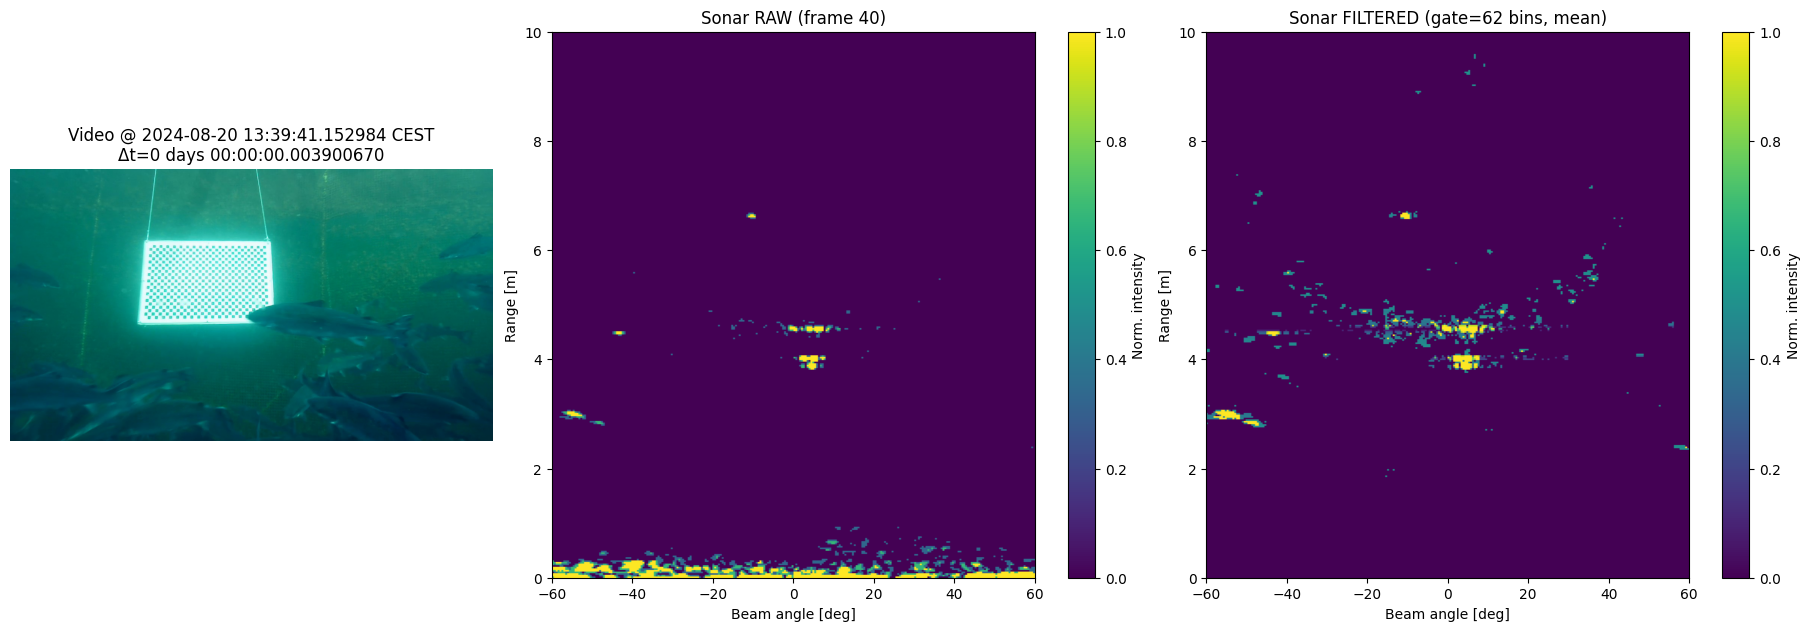

Matched video: 20240820_133941_152984+0200.png | Δt=0 days 00:00:00.003900670


In [45]:
# === Sonar + Video side-by-side with SAME FILTERING (gate + per-row BG + percentile stretch) ===
import json, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from datetime import datetime, timezone

# ---------- CONFIG ----------
SONAR_FILE      = Path("exports/by_bag/sensor_sonoptix_echo_image__2024-08-20_13-39-34_video.csv")
VIDEO_SEQ_DIR   = Path("exports/frames/2024-08-20_13-39-34_video__image_compressed_image_data")  # PNGs + index.csv
FRAME_INDEX     = 40
TIME_TOLERANCE  = pd.Timedelta("75ms")

# Sonar geometry / display axes
FOV_DEG         = 120.0
RANGE_MIN_M     = 0.0
RANGE_MAX_M     = 30.0
DISPLAY_RANGE_M = 10.0

# --- SAME FILTERING knobs as before ---
GATE_NEAR_M         = 0.1      # meters to blank near-field; set None to use bins fallback
GATE_BINS_FALLBACK  = 62
ROW_BG_METHOD       = "mean"  # 'median' or 'mean'
CLIP_LOW_PCT        = 0.1
CLIP_HIGH_PCT       = 85.0
# -------------------------------------

# If your sonar array looks mirrored, flip here (rows=range, cols=beams)
FLIP_BEAMS = False
FLIP_RANGE = False

# ---------- helpers ----------
def load_df(path: Path) -> pd.DataFrame:
    if not path.exists(): raise FileNotFoundError(path)
    return pd.read_parquet(path) if path.suffix.lower()==".parquet" else pd.read_csv(path)

def parse_json_cell(v):
    if isinstance(v, str):
        try: return json.loads(v)
        except Exception: return None
    return v

def infer_hw(labels, sizes, data_len):
    labels = [str(l or "").lower() for l in (labels or [])]
    sizes  = [int(s) for s in (sizes or [])]
    # try by semantic labels first
    try:
        h_idx = max(i for i,l in enumerate(labels) if any(k in l for k in ("height","rows","beams")))
        w_idx = max(i for i,l in enumerate(labels) if any(k in l for k in ("width","cols","bins","range","samples")))
        H, W = sizes[h_idx], sizes[w_idx]
        if H>0 and W>0 and H*W==data_len: return H, W
    except Exception:
        pass
    # brute-force pairs
    for i in range(len(sizes)):
        for j in range(i+1, len(sizes)):
            H, W = sizes[i], sizes[j]
            if H>0 and W>0 and H*W==data_len:
                return H, W
    return None, None

def get_sonoptix_frame(df: pd.DataFrame, idx: int):
    """Return 2D numpy array (rows=range, cols=beams) or None."""
    if not (0 <= idx < len(df)): return None
    row = df.iloc[idx]
    if "image" in df.columns and pd.notna(row.get("image", np.nan)):
        img = parse_json_cell(row["image"])
        if isinstance(img, list) and img and isinstance(img[0], list):
            return np.asarray(img, dtype=np.float32)
    if "data" in df.columns and pd.notna(row.get("data", np.nan)):
        data   = parse_json_cell(row["data"])
        labels = parse_json_cell(row.get("dim_labels"))
        sizes  = parse_json_cell(row.get("dim_sizes"))
        if isinstance(data, list):
            if isinstance(sizes, list):
                H, W = infer_hw(labels, sizes, len(data))
                if H and W: return np.asarray(data, dtype=np.float32).reshape(H, W)
            H = int(row["rows"]) if "rows" in df.columns and pd.notna(row.get("rows")) else None
            W = int(row["cols"]) if "cols" in df.columns and pd.notna(row.get("cols")) else None
            if H and W and H*W==len(data):
                return np.asarray(data, dtype=np.float32).reshape(H, W)
    return None

def scale_to_unit(img, low_pct=1.0, high_pct=99.7):
    """Robust percentile stretch → [0,1], same idea as your scale_to_u8."""
    img = np.asarray(img, dtype=np.float32)
    flat = img.ravel()
    nz = flat[flat > 0]
    ref = nz if nz.size >= 100 else flat
    if ref.size == 0:
        return np.zeros_like(img, dtype=np.float32)
    vmin = np.percentile(ref, low_pct)
    vmax = np.percentile(ref, high_pct)
    if not np.isfinite(vmin): vmin = 0.0
    if (not np.isfinite(vmax)) or vmax <= vmin: vmax = vmin + 1.0
    out = (img - vmin) / (vmax - vmin)
    return np.clip(out, 0, 1)

def infer_total_range_m(row) -> float | None:
    # Use explicit metadata if present; else None (we'll use bins fallback)
    for key in ("range_max_m", "sonar_range", "max_range_m", "range_m"):
        if key in row and pd.notna(row[key]):
            try: return float(row[key])
            except Exception: pass
    return None

def read_video_index(seq_dir: Path) -> pd.DataFrame:
    if not seq_dir.exists(): raise FileNotFoundError(seq_dir)
    idx_path = seq_dir / "index.csv"
    if idx_path.exists():
        dfv = pd.read_csv(idx_path)
        if "ts_utc" in dfv.columns:
            dfv["ts_utc"] = pd.to_datetime(dfv["ts_utc"], utc=True)
        elif "t_use" in dfv.columns:
            dfv["ts_utc"] = pd.to_datetime(dfv["t_use"], unit="s", utc=True)
        else:
            raise RuntimeError("index.csv missing ts_utc/t_use columns.")
        if "file" not in dfv.columns:
            dfv["file"] = [p.name for p in sorted(seq_dir.glob("*.png"))]
        return dfv[["file","ts_utc"]].sort_values("ts_utc").reset_index(drop=True)
    # fallback: parse from filenames like YYYYmmdd_HHMMSS_micro+ZZZZ.png
    rows = []
    rx = re.compile(r"(\d{8})_(\d{6})_(\d{6})([+\-]\d{4})")
    for p in sorted(seq_dir.glob("*.png")):
        m = rx.search(p.stem)
        if not m: continue
        ymd, hms, micro, tz = m.groups()
        dt = datetime.strptime(ymd+hms+micro+tz, "%Y%m%d%H%M%S%f%z")
        rows.append({"file": p.name, "ts_utc": dt.astimezone(timezone.utc)})
    if not rows:
        raise FileNotFoundError("No index.csv and could not parse timestamps from filenames.")
    return pd.DataFrame(rows).sort_values("ts_utc").reset_index(drop=True)

def load_png_rgb(path: Path) -> np.ndarray:
    bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if bgr is None: raise FileNotFoundError(path)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# ---------- load sonar + pick frame ----------
dfs = load_df(SONAR_FILE)
if "ts_utc" not in dfs.columns:
    if "t" not in dfs.columns:
        raise RuntimeError("Sonar file missing 't' or 'ts_utc' column for timestamps.")
    dfs["ts_utc"] = pd.to_datetime(dfs["t"], unit="s", utc=True)

M0 = get_sonoptix_frame(dfs, FRAME_INDEX)
if M0 is None:
    raise RuntimeError("Could not construct a Sonoptix frame from this file.")
M = M0.copy()
if FLIP_RANGE: M = M[::-1, :]
if FLIP_BEAMS: M = M[:, ::-1]
H, W = M.shape

# ---------- SAME FILTERING ----------
# 1) near-field gate (by meters if we can, else fallback in bins)
row_meta = dfs.iloc[FRAME_INDEX].to_dict()
range_total_m = infer_total_range_m(row_meta)
if GATE_NEAR_M is not None and range_total_m and range_total_m > 0:
    gate_bins = int(round(GATE_NEAR_M / range_total_m * H))
else:
    gate_bins = int(GATE_BINS_FALLBACK)
gate_bins = max(0, min(gate_bins, H))

gated = M.copy()
if gate_bins > 0:
    gated[:gate_bins, :] = 0.0

# 2) per-row background (median or mean)
if ROW_BG_METHOD == "median":
    bg_row = np.median(gated, axis=1, keepdims=True)
else:
    bg_row = np.mean(gated, axis=1, keepdims=True)

filtered = gated - bg_row
filtered[filtered < 0] = 0.0

# 3) robust percentile stretch → [0,1]
M_raw_disp      = scale_to_unit(M,       CLIP_LOW_PCT, CLIP_HIGH_PCT)
M_filtered_disp = scale_to_unit(filtered, CLIP_LOW_PCT, CLIP_HIGH_PCT)

# ---------- load video + match by timestamp ----------
dfv = read_video_index(VIDEO_SEQ_DIR)
dfv["ts_utc"] = pd.to_datetime(dfv["ts_utc"], utc=True, errors="coerce")
dfv = dfv.dropna(subset=["ts_utc"]).sort_values("ts_utc").reset_index(drop=True)
if dfv.empty: raise RuntimeError("Video index has no valid timestamps.")

ts_target = pd.to_datetime(dfs.loc[FRAME_INDEX, "ts_utc"], utc=True)
idx_near  = pd.Index(dfv["ts_utc"]).get_indexer([ts_target], method="nearest")[0]
if idx_near < 0: raise RuntimeError("Could not find a nearest video frame (indexer returned -1).")
dt_best = abs(dfv.loc[idx_near, "ts_utc"] - ts_target)

video_file = VIDEO_SEQ_DIR / dfv.loc[idx_near, "file"]
img_rgb = load_png_rgb(video_file)

# ---------- plot: Video | Sonar (raw) | Sonar (filtered) ----------
theta_min_deg = -0.5 * FOV_DEG
theta_max_deg =  0.5 * FOV_DEG
extent_xy = (theta_min_deg, theta_max_deg, RANGE_MIN_M, RANGE_MAX_M)

fig, axes = plt.subplots(1, 3, figsize=(18, 6.2), constrained_layout=True)

# Video
axes[0].imshow(img_rgb)
axes[0].set_title(f"Video @ {dfv.loc[idx_near, 'ts_utc'].tz_convert('Europe/Oslo'):%Y-%m-%d %H:%M:%S.%f %Z}\nΔt={dt_best}")
axes[0].axis("off")

# Sonar raw (stretched for visibility only)
im0 = axes[1].imshow(M_raw_disp, origin="lower", aspect="auto", extent=extent_xy, cmap="viridis")
axes[1].set_title(f"Sonar RAW (frame {FRAME_INDEX})")
axes[1].set_xlabel("Beam angle [deg]"); axes[1].set_ylabel("Range [m]")
axes[1].set_ylim(RANGE_MIN_M, DISPLAY_RANGE_M)
fig.colorbar(im0, ax=axes[1], label="Norm. intensity")

# Sonar filtered (same gate + per-row BG + stretch)
im1 = axes[2].imshow(M_filtered_disp, origin="lower", aspect="auto", extent=extent_xy, cmap="viridis")
axes[2].set_title(f"Sonar FILTERED (gate={gate_bins} bins, {ROW_BG_METHOD})")
axes[2].set_xlabel("Beam angle [deg]"); axes[2].set_ylabel("Range [m]")
axes[2].set_ylim(RANGE_MIN_M, DISPLAY_RANGE_M)
fig.colorbar(im1, ax=axes[2], label="Norm. intensity")

plt.show()

print(f"Matched video: {video_file.name} | Δt={dt_best}")
